In [2]:
import sys
assert sys.version_info >=(3,5)
import sklearn
assert sklearn.__version__>="0.20"
try:
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.15.0rc0
    print("You can safely ignore the package")
except Exception:
    pass
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
PROJECT_ROOT_DIR = "."
CHAPTER_ID ="data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images",CHAPTER_ID)
os.makedirs(IMAGES_PATH,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png",resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "."+fig_extension)
    print("SAving Figure",fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)

Datasets

In [3]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [4]:
dataset = tf.data.Dataset.range(10)

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [6]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [7]:
dataset = dataset.map(lambda x:x *2)

In [8]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [9]:
dataset = dataset.apply(tf.data.experimental.unbatch())

W0215 07:13:00.485590 12428 deprecation.py:323] From <ipython-input-9-15e8a30c9761>:1: unbatch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


In [10]:
dataset = dataset.filter(lambda x: x< 10)

In [11]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [12]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3,seed=42).batch(7)
for item in dataset:
    print(item)

W0215 07:13:01.402057 12428 deprecation.py:323] From c:\users\microsoft\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\data\util\random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tf.Tensor([0 3 4 2 1 5 8], shape=(7,), dtype=int64)
tf.Tensor([6 9 7 2 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([6 0 7 9 0 1 2], shape=(7,), dtype=int64)
tf.Tensor([8 4 5 5 3 8 9], shape=(7,), dtype=int64)
tf.Tensor([7 6], shape=(2,), dtype=int64)


# Split the California dataset to multiple CSV files

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,housing.target.reshape(-1,1),random_state=42)
X_train, X_valid, y_train, y_valid =train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_


For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [14]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [15]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [16]:
import pandas as pd
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [17]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(),end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [18]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

# Building an Input Pipeline

In [19]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths,seed=42)

In [20]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [21]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length = n_readers)

In [22]:
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


In [23]:
record_defaults = [0, np.nan, tf.constant(np.nan,dtype = tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5',record_defaults)
parsed_fields

[<tf.Tensor: id=208, shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: id=209, shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: id=210, shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: id=211, shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: id=212, shape=(), dtype=float32, numpy=5.0>]

In [24]:
parsed_fields = tf.io.decode_csv(',,,,5',record_defaults)
parsed_fields

[<tf.Tensor: id=217, shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: id=218, shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: id=219, shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: id=220, shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: id=221, shape=(), dtype=float32, numpy=5.0>]

In [25]:
try:
    parsed_fields =tf.io.decode_csv('1,2,3,4,5,6,7',record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [26]:
n_inputs = 8
@tf.function 
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([],dtype = tf.float32)]
    fields = tf.io.decode_csv(line,record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean)/X_std, y

In [27]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: id=256, shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: id=257, shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.46684855 -0.36583957 -0.05962267 -0.1774168   0.7261798   0.20453875
  -0.6682526   0.2770543 ]
 [-1.0901837  -0.20762321 -0.5472499  -0.06244746  0.58655065  0.25357732
  -1.3616015   1.2515981 ]
 [-0.41689095  1.6118649  -0.55744225 -0.0718101  -0.32697055 -0.22236001
  -0.72447133  0.65187943]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.142]
 [1.247]
 [2.109]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.85580134  1.1372159  -0.5474913  -0.14085676 -0.42188185 -0.5590057
  -1.3616015   1.2166146 ]
 [ 0.5231527  -0.60316414 -0.03883119 -0.20682292 -0.47481313  0.03595542
  -0.85564494  0.8467882 ]
 [ 0.64094615  0.42524222 -0.00933153 -0.30455127  0.732568    0.21825889
  -0.860329    0.7818199 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.636]
 [1.791]
 [2.009]], shape=(3, 1), dtype=float32)



In [30]:
train_set = csv_reader_dataset(train_filepaths,repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [31]:
!pip install keras


In [32]:
from tensorflow import keras

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(30,activation='relu',input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [34]:
model.compile(loss="mse",optimizer=keras.optimizers.SGD(lr=1e-3))

In [35]:
batch_size =32
model.fit(train_set, steps_per_epoch=len(X_train)//batch_size,epochs=10,
         validation_data = valid_set)

Train for 362 steps
Epoch 1/10
362/362 [==============================] - 4s 10ms/step - loss: 2.1248 - val_loss: 0.7573
Epoch 2/10
362/121 [=========================================================================================] - 1s 3ms/step - loss: 0.5693 - val_loss: 0.8840
Epoch 3/10
362/121 [=========================================================================================] - 1s 3ms/step - loss: 0.4953 - val_loss: 0.5788
Epoch 4/10
362/121 [=========================================================================================] - 1s 3ms/step - loss: 0.4405 - val_loss: 0.5355
Epoch 5/10
362/121 [=========================================================================================] - 1s 2ms/step - loss: 0.5135 - val_loss: 0.5212
Epoch 6/10
362/121 [=========================================================================================] - 1s 3ms/step - loss: 0.5662 - val_loss: 0.4979
Epoch 7/10
362/121 [================================================================

In [36]:
model.evaluate(test_set, steps=len(X_test)//batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.4467


0.4466616385008978

In [37]:
new_set = test_set.map(lambda X,y :X)
X_new = X_test
model.predict(new_set,steps=len(X_new)//batch_size)

array([[3.6641655],
       [1.5517101],
       [2.0916123],
       ...,
       [1.4571147],
       [1.6457071],
       [2.045387 ]], dtype=float32)

In [38]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train)//batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step +=1
    print("\r Global Step {}/{}".format(global_step,total_steps),end="")
    with tf.GradientTape() as tape:
        y_pred =model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch,y_pred))
        loss = tf.add_n([main_loss]+ model.losses)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

 Global Step 1810/1810

In [39]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

In [40]:
@tf.function
def train(model,n_epochs, batch_size=32,
         n_readers=5,n_read_threads=5,shuffle_buffer_size=10000,
         n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths,repeat=n_epochs,n_readers=n_readers,
                          n_read_threads= n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                          n_parse_threads=n_parse_threads,batch_size=batch_size)
    for X_batch,y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch,y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
train(model,5)        

In [41]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
@tf.function

def train(model,n_epochs, batch_size=32,
         n_readers=5, n_read_threads=5, shuffle_buffer_size=10000,n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat = n_epochs, n_readers =n_readers,
                                  n_read_threads = n_read_threads, shuffle_buffer_size= shuffle_buffer_size,
                                  n_parse_threads= n_parse_threads, batch_size = batch_size)
    n_steps_per_epcoh = len(X_train)//batch_size
    total_steps= n_epochs * n_steps_per_epoch
    global_step =0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step %100,0):
            tf.print("\r Global step ", global_step,"/",total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch,y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
        
train(model,5)
            

 Global step  100 / 1810
 Global step  200 / 1810
 Global step  300 / 1810
 Global step  400 / 1810
 Global step  500 / 1810
 Global step  600 / 1810
 Global step  700 / 1810
 Global step  800 / 1810
 Global step  900 / 1810
 Global step  1000 / 1810
 Global step  1100 / 1810
 Global step  1200 / 1810
 Global step  1300 / 1810
 Global step  1400 / 1810
 Global step  1500 / 1810
 Global step  1600 / 1810
 Global step  1700 / 1810
 Global step  1800 / 1810


In [42]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset,m)
        if hasattr(func,"__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()         Maps `map_func` across this dataset, and interleaves the results.
● list_files()         A da

# The TFRecord binary format

In [44]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [45]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [48]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [50]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord",options)as f:
    f.write(b"This is the first record")
    f.write(b"This is the second record")

In [51]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                 compression_type= "GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'This is the second record', shape=(), dtype=string)


# A Brief Intro to Protocol Buffers

In [53]:
%%writefile person.proto
syntax ="proto3";
message Person{
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


In [54]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [55]:
!ls person*

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [56]:
from person_pb2 import Person

In [57]:
person = Person(name="Al",id=123,email=["a@b.com"])
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [58]:
person.name

'Al'

In [59]:
person.email[0]

'a@b.com'

In [60]:
person.email.append("c@d.com")

In [61]:
s = person.SerializeToString()
s

b'\n\x02Al\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [62]:
person2 = Person()
person2.ParseFromString(s)

24

In [63]:
person==person2

True

# Custom Protobuf

In [66]:
person_tf = tf.io.decode_proto(
    bytes = s,
    message_type = "Person",
    field_names = ["name","id","email"],
    output_types = [tf.string,tf.int32,tf.string],
    descriptor_source="person.desc")
person_tf.values

[<tf.Tensor: id=344333, shape=(1,), dtype=string, numpy=array([b'Al'], dtype=object)>,
 <tf.Tensor: id=344334, shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: id=344335, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

# Tensorflow Protobufs

In [69]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [71]:
feature_description ={
    "name": tf.io.FixedLenFeature([],tf.string,default_value=""),
    "id": tf.io.FixedLenFeature([],tf.int64,default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

In [72]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f403f2388>,
 'id': <tf.Tensor: id=344363, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=344364, shape=(), dtype=string, numpy=b'Alice'>}

In [73]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f403f2388>,
 'id': <tf.Tensor: id=344363, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=344364, shape=(), dtype=string, numpy=b'Alice'>}

In [74]:
parsed_example["emails"].values[0]

<tf.Tensor: id=344368, shape=(), dtype=string, numpy=b'a@b.com'>

In [75]:
tf.sparse.to_dense(parsed_example["emails"],default_value=b"")

<tf.Tensor: id=344370, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [76]:
parsed_example["emails"].values

<tf.Tensor: id=344361, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

# Putting Images in TFrecords

In [77]:
from sklearn.datasets import load_sample_images

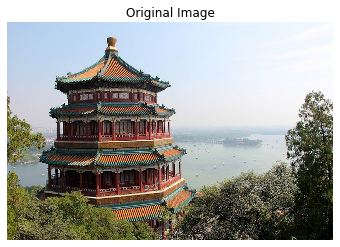

In [78]:
img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [79]:
data = tf.io.encode_jpeg(img)
example_with_image =Example(features = Features(feature={
    "image":Feature(bytes_list = BytesList(value=[data.numpy()]))
}))
serialized_example = example_with_image.SerializeToString()

In [80]:
feature_description ={"image":tf.io.VarLenFeature(tf.string)}
example_with_image = tf.io.parse_single_example(serialized_example,feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

In [81]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

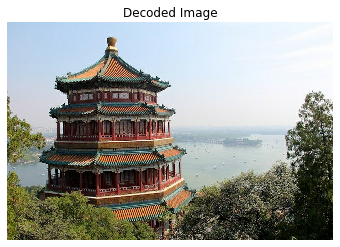

In [82]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

# Putting Tensors and Sparse Tensors in TRRecords

In [83]:
t = tf.constant([[0.,1.],[2.,3.],[4.,5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: id=344399, shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [84]:
tf.io.parse_tensor(s, out_type = tf.float32)

<tf.Tensor: id=344400, shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [85]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: id=344401, shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [86]:
BytesList(value= serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [88]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [89]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f40881108>}

In [93]:
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [94]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [95]:
serialized_sequence_example = sequence_example.SerializeToString()

In [96]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [97]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f4086ed08>,
 'author_id': <tf.Tensor: id=344465, shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: id=344466, shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [98]:
parsed_context["title"].values

<tf.Tensor: id=344463, shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [99]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f4086ebc8>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x24f4086e788>}

In [101]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# The Features API

In [103]:
import os
import tarfile
import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("dataset","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [104]:
fetch_housing_data()

In [105]:
import pandas as pd

In [107]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [108]:
housing = load_housing_data()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [109]:
housing_median_age =tf.feature_column.numeric_column("housing_median_age")

In [110]:
age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column(
"housing_median_age",normalizer_fn =lambda x:(x - age_mean)/age_std)

In [112]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income =tf.feature_column.bucketized_column(
    median_income, boundaries = [1.5,3.,4.5,6.])

In [113]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [114]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity",ocean_prox_vocab)

In [115]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [116]:
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city",hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [117]:
bucketized_age= tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1.,-0.5,0.,0.5,1.])
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age,ocean_proximity],hash_bucket_size=100)

In [118]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [119]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [120]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

In [121]:

median_house_value = tf.feature_column.numeric_column("median_house_value")

In [122]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [123]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [124]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

In [125]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Train for 362 steps
Epoch 1/5
362/362 [==============================] - 1s 2ms/step - loss: 3.7272 - accuracy: 0.0019
Epoch 2/5
362/362 [==============================] - 1s 2ms/step - loss: 1.8900 - accuracy: 0.0029
Epoch 3/5
362/362 [==============================] - 1s 2ms/step - loss: 1.4496 - accuracy: 0.0033
Epoch 4/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3394 - accuracy: 0.0027 ETA: 0s - loss: 1.3357 
Epoch 5/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3586 - accuracy: 0.0028


In [126]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

W0215 08:35:39.044769 12428 deprecation.py:323] From c:\users\microsoft\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:3089: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0215 08:35:39.048766 12428 deprecation.py:323] From c:\users\microsoft\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:353: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


<tf.Tensor: id=350608, shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.26776809, -0.10791849],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.62128323,  1.0724137 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.62128323,  1.0724137 ]], dtype=float32)>

In [127]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform
